In [1]:
from google.colab import drive
drive.mount("/gdrive", force_remount=True)

Mounted at /gdrive


In [2]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import (DataLoader, TensorDataset)
from sklearn.metrics import accuracy_score

#모델 설계
class SpacingRNN(nn.Module):

    def __init__(self, config):
        super(SpacingRNN, self).__init__()

        # 전체 음절 개수
        self.eumjeol_vocab_size = config["eumjeol_vocab_size"]

        # 음절 임베딩 사이즈
        self.embedding_size = config["embedding_size"]

        # RNN 히든 사이즈
        self.hidden_size = config["hidden_size"]

        # 분류할 라벨의 개수
        self.number_of_labels = config["number_of_labels"]

        # 임베딩층: 랜덤 초기화 후 fine-tuning
        # 이곳을 채우세요.
        self.embedding = nn.Embedding(num_embeddings=self.eumjeol_vocab_size, embedding_dim=self.embedding_size, padding_idx=0)

        self.dropout = nn.Dropout(config["dropout"])

        # RNN layer
        # 이곳을 채우세요.
        #self.bi_gru = nn.GRU(input_size=self.embedding_size, hidden_size=self.hidden_size, num_layers=1, batch_first=True, bidirectional=True)
        self.bi_lstm = nn.LSTM(input_size=self.embedding_size, hidden_size=self.hidden_size, num_layers=2, batch_first=True, bidirectional=True)

        # fully_connected layer를 통하여 출력 크기를 number_of_labels에 맞춰줌
        # 이곳을 채우세요.
        #(batch_size, max_length, hidden_size*2)-> (batch_size, max_length, number_of_labels)
        self.linear = nn.Linear(in_features=self.hidden_size * 2, out_features=self.number_of_labels) #곱하기 2는 양방향이기 때문(bidirectional)


    def forward(self, inputs):
        # (batch_size, max_length) -> (batch_size, max_length, embedding_size)
        eumjeol_inputs = self.embedding(inputs) #idx -> embedding(maxlength만큼 있는것이 batch만큼 있음)

        # hidden_outputs, hidden_states = self.bi_gru(eumjeol_inputs)
        hidden_outputs, hidden_states = self.bi_lstm(eumjeol_inputs) #두개 output을 hidden_output위에 올림

        # (batch_size, max_length, hidden_size*2)
        hidden_outputs = self.dropout(hidden_outputs)

        # (batch_size, max_length, hidden_size*2) -> (batch_size, max_length, number_of_labels)
        hypothesis = self.linear(hidden_outputs)

        return hypothesis

In [3]:
# 데이터를 읽어 리스트에 저장
def read_datas(file_path):
    with open(file_path, "r", encoding="utf8") as inFile:
        lines = inFile.readlines()
    datas = []
    for line in lines:
        # 입력 문장을 \t으로 분리
        pieces = line.strip().split("\t")
        # 입력 문자열을 음절 단위로 분리
        eumjeol_sequence, label_sequence = pieces[0].split(), pieces[1].split() #[0]이 input [1]이 label
        datas.append((eumjeol_sequence, label_sequence))
    return datas

# 데이터를 읽고 각각의 딕셔너리 생성
def read_vocab_data(eumjeol_vocab_data_path): #음절을 다 쪼갠다음에 unique sort
    label2idx, idx2label = {"<PAD>":0, "B":1, "I":2}, {0:"<PAD>", 1:"B", 2:"I"}
    eumjeol2idx, idx2eumjeol = {}, {}

    with open(eumjeol_vocab_data_path, "r", encoding="utf8") as inFile:
        lines = inFile.readlines()

    for line in lines:
        eumjeol = line.strip()
        eumjeol2idx[eumjeol] = len(eumjeol2idx) #eumjeol을 key로 함 0, 1, 2, ...
        idx2eumjeol[eumjeol2idx[eumjeol]] = eumjeol

    return eumjeol2idx, idx2eumjeol, label2idx, idx2label

def load_dataset(config):
    datas = read_datas(config["input_data"])
    eumjeol2idx, idx2eumjeol, label2idx, idx2label = read_vocab_data(config["eumjeol_vocab"])

    # 음절 데이터, 각 데이터의 실제 길이, 라벨 데이터를 담을 리스트
    eumjeol_features, eumjeol_feature_lengths, label_features = [], [], []

    for eumjeol_sequence, label_sequence in datas:
        eumjeol_feature = [eumjeol2idx[eumjeol] for eumjeol in eumjeol_sequence] #음절을 feature화(숫자로 바꿈)
        label_feature = [label2idx[label] for label in label_sequence]

        # 음절 sequence의 실제 길이
        eumjeol_feature_length = len(eumjeol_feature)

        # 모든 입력 데이터를 고정된 길이로 맞춰주기 위한 padding 처리
        # 이곳을 채우세요.
        eumjeol_feature += [0] * (config["max_length"] - eumjeol_feature_length)
        label_feature += [0] * (config["max_length"] - eumjeol_feature_length)

        # 변환한 데이터를 각 리스트에 저장
        eumjeol_features.append(eumjeol_feature)
        eumjeol_feature_lengths.append(eumjeol_feature_length)
        label_features.append(label_feature)

    # 변환한 데이터를 Tensor 객체에 담아 반환
    eumjeol_features = torch.tensor(eumjeol_features, dtype=torch.long)
    eumjeol_feature_lengths = torch.tensor(eumjeol_feature_lengths, dtype=torch.long)
    label_features = torch.tensor(label_features, dtype=torch.long)

    return eumjeol_features, eumjeol_feature_lengths, label_features, eumjeol2idx, idx2eumjeol, label2idx, idx2label

In [4]:
def train(config):
    # RNN 모델 객체 생성
    model = SpacingRNN(config).cuda()

    # 데이터 읽기
    eumjeol_features, eumjeol_feature_lengths, label_features, eumjeol2idx, idx2eumjeol, label2idx, idx2label = load_dataset(config)

    # 학습 데이터를 batch 단위로 추출하기 위한 DataLoader 객체 생성
    train_features = TensorDataset(eumjeol_features, eumjeol_feature_lengths, label_features)
    train_dataloader = DataLoader(train_features, shuffle=True, batch_size=config["batch_size"])

    # 크로스엔트로피 비용 함수, padding은 계산하지 않음
    # 이곳을 채우세요.
    loss_func = nn.CrossEntropyLoss()
    

    # 모델 학습을 위한 optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(config["epoch"]):

        model.train()
        costs = []

        for step, batch in enumerate(train_dataloader):

            # 역전파 단계를 실행하기 전에 변화도를 0으로 변경
            optimizer.zero_grad()

            batch = tuple(t.cuda() for t in batch)

            # 음절 데이터, 각 데이터의 실제 길이, 라벨 데이터
            inputs, input_lengths, labels = batch[0], batch[1], batch[2]

            # 모델 출력 결과 얻어오기
            hypothesis = model(inputs)

            # hypothesis : (batch_size, max_length, number_of_labels) -> (batch_size*max_length, number_of_labels)
            # labels : (batch_size, max_length) -> (batch_size*max_length, )
            # 이곳을 채우세요.
            cost = loss_func(hypothesis.reshape(-1, len(label2idx)), labels.flatten()) 
            
            cost.backward()
            optimizer.step()

            # batch 단위 cost 값 저장
            costs.append(cost.data.item())

        torch.save(model.state_dict(), os.path.join(output_dir, "epoch_{0:d}.pt".format(epoch + 1)))

        # epoch 별로 평균 loss 값과 정확도 출력
        print("Average cost : {}".format(np.mean(costs)))

In [5]:
# 모델 출력 라벨 sequence와 정답 라벨 sequence를 기반으로
# 모델 출력 문장과 정답 문장 출력
def make_sentence(inputs, predicts, labels, idx2eumjeol, idx2label):

    predict_sentence, correct_sentence = "", ""

    for index in range(len(inputs)):
        eumjeol = idx2eumjeol[inputs[index]]
        correct_label = idx2label[labels[index]]
        predict_label = idx2label[predicts[index]]

        # 시작 음절인 경우 공백을 추가해줄 필요가 없음
        if (index == 0):
            predict_sentence += eumjeol
            correct_sentence += eumjeol
            continue

        # "B" 태그인 경우 어절의 시작 음절이므로 앞에 공백을 추가
        if (predict_label == "B"):
            predict_sentence += " "
        predict_sentence += eumjeol

        # "B" 태그인 경우 어절의 시작 음절이므로 앞에 공백을 추가
        if (correct_label == "B"):
            correct_sentence += " "
        correct_sentence += eumjeol

    return predict_sentence, correct_sentence

# 텐서를 리스트로 변환하는 함수
def tensor2list(input_tensor):
    return input_tensor.cpu().detach().numpy().tolist()

def test(config):
    # 데이터 읽기
    eumjeol_features, eumjeol_feature_lengths, label_features, eumjeol2idx, idx2eumjeol, label2idx, idx2label = load_dataset(config)

    # 평가 데이터를 batch 단위로 추출하기 위한 DataLoader 객체 생성
    test_features = TensorDataset(eumjeol_features, eumjeol_feature_lengths, label_features)
    test_dataloader = DataLoader(test_features, shuffle=False, batch_size=1)

    # RNN 모델 객체 생성
    model = SpacingRNN(config).cuda()
    # 사전학습한 모델 파일로부터 가중치 불러옴
    model.load_state_dict(torch.load(os.path.join(config["output_dir_path"], config["model_name"])))

    # 모델의 출력 결과와 실제 정답값을 담을 리스트
    total_hypothesis, total_labels = [], []

    for step, batch in enumerate(test_dataloader):

        model.eval()
        batch = tuple(t.cuda() for t in batch)

        # 음절 데이터, 각 데이터의 실제 길이, 라벨 데이터
        inputs, input_lengths, labels = batch[0], batch[1], batch[2]

        # 모델 평가
        hypothesis = model(inputs)

        # (batch_size, max_length, number_of_labels) -> (batch_size, max_length) -> 3차원 argmax
        hypothesis = torch.argmax(hypothesis, dim=-1)

        # batch_size가 1이기 때문
        input_length = tensor2list(input_lengths[0])
        input = tensor2list(inputs[0])[:input_length]
        label = tensor2list(labels[0])[:input_length]
        hypothesis = tensor2list(hypothesis[0])[:input_length]

        # 출력 결과와 정답을 리스트에 저장
        total_hypothesis += hypothesis
        total_labels += label

        if (step < 10):
            # 정답과 모델 출력 비교
            predict_sentence, correct_sentence = make_sentence(input, hypothesis, label, idx2eumjeol, idx2label)
            print("정답 : " + correct_sentence)
            print("출력 : " + predict_sentence)
            print()

    # 정확도 출력
    print("Accuracy : {}".format(accuracy_score(total_labels, total_hypothesis)))

In [7]:
if(__name__=="__main__"):
    root_dir = "/gdrive/My Drive/colab/rnn/spacing"
    output_dir = os.path.join(root_dir, "output")
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    config = {"mode": "train",
              "model_name":"epoch_{0:d}.pt".format(5),
              "input_data":os.path.join(root_dir, "train.txt"),
              "output_dir_path":output_dir,
              "eumjeol_vocab": os.path.join(root_dir, "eumjeol_vocab.txt"),
              "label_vocab": os.path.join(root_dir, "label_vocab.txt"),
              "eumjeol_vocab_size": 2458,
              "embedding_size": 100,
              "hidden_size": 100,
              "max_length": 920,
              "number_of_labels": 3,
              "epoch":10,
              "batch_size":64,
              "dropout":0.3
              }

    if(config["mode"] == "train"):
        train(config)
    else:
        test(config)

Average cost : 0.13116733040189063
Average cost : 0.021615120275771317
Average cost : 0.0160818638728012
Average cost : 0.01034575253371385
Average cost : 0.00825668304946415
Average cost : 0.00699159334991363
Average cost : 0.0060776818950389385
Average cost : 0.0055453383122111045
Average cost : 0.004915052993942194
Average cost : 0.004450189866290628


In [8]:
if(__name__=="__main__"):
    root_dir = "/gdrive/My Drive/colab/rnn/spacing"
    output_dir = os.path.join(root_dir, "output")
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    config = {"mode": "test",
              "model_name":"epoch_{0:d}.pt".format(5),
              "input_data":os.path.join(root_dir, "train.txt"),
              "output_dir_path":output_dir,
              "eumjeol_vocab": os.path.join(root_dir, "eumjeol_vocab.txt"),
              "label_vocab": os.path.join(root_dir, "label_vocab.txt"),
              "eumjeol_vocab_size": 2458,
              "embedding_size": 100,
              "hidden_size": 100,
              "max_length": 920,
              "number_of_labels": 3,
              "epoch":10,
              "batch_size":64,
              "dropout":0.3
              }

    if(config["mode"] == "train"):
        train(config)
    else:
        test(config)

정답 : 부인이 정성들여 키운 진이 독살되었다는 것은 연박사에게도 매우 가슴아픈 일일 것이다.
출력 : 부인이 정성들여키운진이 독살되었다는 것은 연박사에게도 매우가슴 아픈일일 것이다.

정답 : 이같은 그의 가난은 어려서만이 아니라 자란 뒤에도 늙을 때까지 줄기차게 계속되었다.
출력 : 이 같은 그의 가난은 어려서만이 아니라 자란 뒤에도 늙을 때까지 줄기차게 계속되었다.

정답 : 어느 물리학자의 머리 속.
출력 : 어느물리학자의 머리속.

정답 : 말씨며 움직임이 세련되어 있었다.
출력 : 말 씨며 움직임이 세련되어 있었다.

정답 : "워싱턴과 뉴욕에서 차출한 인원까지 모두 12 명이네."
출력 : "워싱턴과 뉴욕에서 차출한 인원까지 모두 1 2명이네."

정답 : "그 사람을 아직도 사랑하나요?"
출력 : "그 사람을 아직도 사랑하나요?"

정답 : "나한테 걸린 건 행복한 거예요. 나를 훔치려는 사내들이 많아요. 무슨 말인지 알아요?"
출력 : "나한테 걸린 건행복한 거예요. 나를 훔치려는 사내들이 많아요. 무슨 말인지 알아요?"

정답 : 김광민은 집에 돌아와 있었으나 그 얘기를 바로 주남 마을과 녹동 마을에서 일어난 일이었기 때문에 자세히 들을 수 있었다.
출력 : 김광민은 집에 돌아와 있었으나 그 얘기를 바로 주남마을 과녹동마을에서 일어난 일이었기 때문에 자세히 들을 수 있었다.

정답 : 미리 이야기해 두는 게 좋을 것 같아."
출력 : 미리이야기해 두는 게 좋을 것 같아."

정답 : "부인의 입장에서 남편의 자살을 얘기하는 말투로는 너무 냉정하다는 생각 안 드세요?"
출력 : "부인의 입장에서 남편의 자살을 얘기하는 말투로는 너무 냉정하다는 생각안드세요?"

Accuracy : 0.9231794285157962


Accuracy : 0.8929149142672275 -> Accuracy : 0.9231794285157962

기존의 num_layers = 1을 num_layers를 2로 변경하여 RNN의 은닉층 개수를 하나 더 추가하였습니다
또한 epoch를 5에서 10으로 변경하였습니다

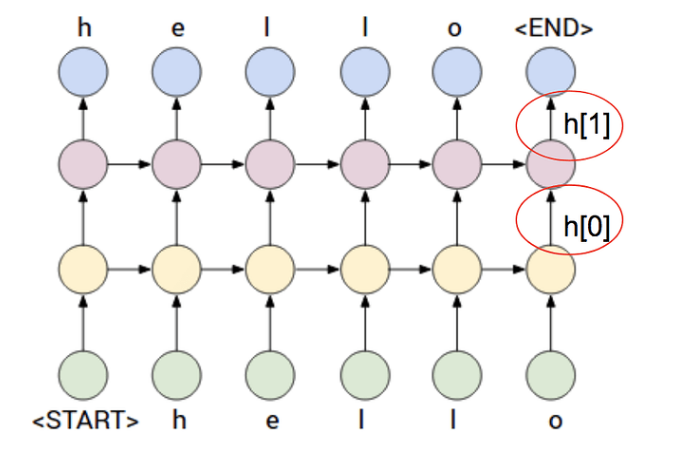

예를들어 신경망의 그림은 다음과 같습니다